In [7]:
import os, sys

# Proje köküne geç
proj_root = "/Users/nurefsanolfaz/yap470_project/xray_anomaly_method1"
os.chdir(proj_root)
sys.path.insert(0, proj_root)

print("Çalışma dizini:", os.getcwd())

Çalışma dizini: /Users/nurefsanolfaz/yap470_project/xray_anomaly_method1


Dataset1 için veri görselleştirmesi gerçekleştirdik.

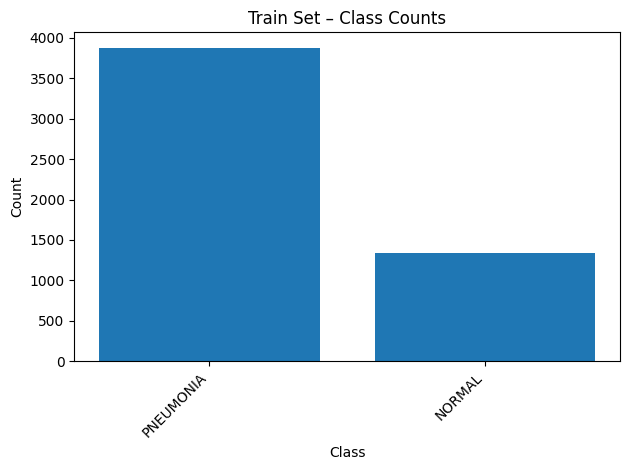

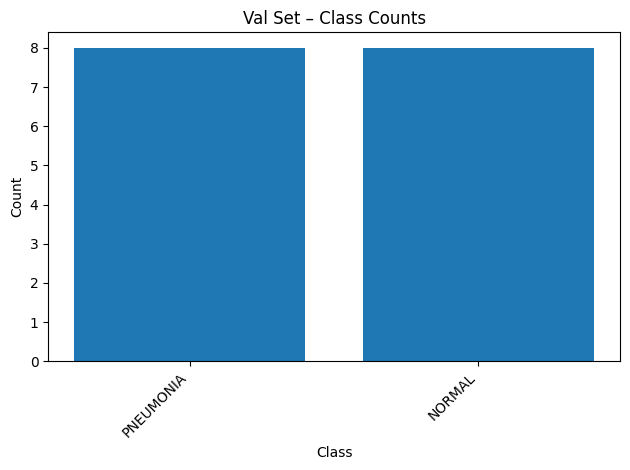

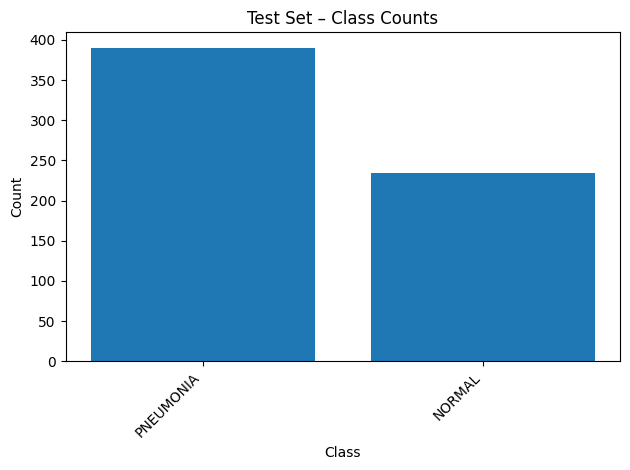

In [8]:
from src.method1.visualization_utils import plot_distribution

plot_distribution("data/raw/dataset1")


In [9]:
from src.method1.preprocessing import batch_preprocess

input_base = "data/raw/dataset1"
output_base = "data/processed/dataset1"

splits = ["train", "val", "test"]

for split in splits:
    split_input_path = os.path.join(input_base, split)
    if not os.path.isdir(split_input_path):
        print(f"Skip: {split_input_path} klasörü bulunamadı.")
        continue

    for class_name in os.listdir(split_input_path):
        class_input_dir = os.path.join(split_input_path, class_name)
        class_output_dir = os.path.join(output_base, split, class_name)

        if os.path.isdir(class_input_dir):
            print(f"⏳ İşleniyor: {split}/{class_name}")
            batch_preprocess(class_input_dir, class_output_dir)
            print(f"✅ Kaydedildi: {class_output_dir}")


⏳ İşleniyor: train/PNEUMONIA
✅ Kaydedildi: data/processed/dataset1/train/PNEUMONIA
⏳ İşleniyor: train/NORMAL
✅ Kaydedildi: data/processed/dataset1/train/NORMAL
⏳ İşleniyor: val/PNEUMONIA
✅ Kaydedildi: data/processed/dataset1/val/PNEUMONIA
⏳ İşleniyor: val/NORMAL
✅ Kaydedildi: data/processed/dataset1/val/NORMAL
⏳ İşleniyor: test/PNEUMONIA
✅ Kaydedildi: data/processed/dataset1/test/PNEUMONIA
⏳ İşleniyor: test/NORMAL
✅ Kaydedildi: data/processed/dataset1/test/NORMAL


In [10]:
import os, random
from skimage.io import imread, imsave
from skimage.transform import rotate

# 1) Ayarlar
DATASET1_TRAIN = "data/processed/dataset1/train"
AUG_TRAIN_DIR  = "data/processed/dataset1/train"
AUG_OPS = ['flip', 'rotate']

# 2) Sınıf başına mevcut görsel sayılarını al
counts = {}
for cls in os.listdir(DATASET1_TRAIN):
    cls_dir = os.path.join(DATASET1_TRAIN, cls)
    if os.path.isdir(cls_dir):
        counts[cls] = len([f for f in os.listdir(cls_dir) if f.lower().endswith(('.png','.jpg','.jpeg'))])
max_count = max(counts.values())
print("Sınıf başına hedef örnek sayısı:", max_count)

# 3) Augmentasyon fonksiyonu
def augment_image(img):
    op = random.choice(AUG_OPS)
    if op == 'flip':
        return img[:, ::-1]              # yatay çevir
    else:  # rotate
        angle = random.choice([90, 180, 270])
        return rotate(img, angle, resize=False, mode='edge')

# 4) Eksik örnekleri tamamla
for cls, cnt in counts.items():
    src_dir = os.path.join(DATASET1_TRAIN, cls)
    dst_dir = os.path.join(AUG_TRAIN_DIR, cls)
    os.makedirs(dst_dir, exist_ok=True)

    # önce orijinalleri kopyala
    for fname in os.listdir(src_dir):
        if not fname.lower().endswith(('.png','.jpg','.jpeg')): continue
        img = imread(os.path.join(src_dir, fname), as_gray=True)
        imsave(os.path.join(dst_dir, fname), img)

    # augmentasyonla eksikleri tamamla
    need = max_count - cnt
    print(f"{cls}: {cnt} → {max_count} için {need} yeni örnek")
    all_files = [f for f in os.listdir(src_dir) if f.lower().endswith(('.png','.jpg','.jpeg'))]
    for i in range(need):
        fname = random.choice(all_files)
        img = imread(os.path.join(src_dir, fname), as_gray=True)
        aug = augment_image(img)
        out_name = f"{os.path.splitext(fname)[0]}_aug{i}.png"
        imsave(os.path.join(dst_dir, out_name), (aug * 255).astype('uint8'))


print("✅ Augmentasyon tamamlandı – tüm sınıflar eşitlendi.")


Sınıf başına hedef örnek sayısı: 3875
PNEUMONIA: 3875 → 3875 için 0 yeni örnek
NORMAL: 1341 → 3875 için 2534 yeni örnek
✅ Augmentasyon tamamlandı – tüm sınıflar eşitlendi.


In [11]:
import os
import shutil

TRAIN_DIR = "data/processed/dataset1/train"

for cls in os.listdir(TRAIN_DIR):
    cls_dir = os.path.join(TRAIN_DIR, cls)
    # Sadece dizinler üzerinde işlem yap
    if not os.path.isdir(cls_dir):
        continue

    # İçinde tek bir alt klasör var mı diye bak
    subs = [d for d in os.listdir(cls_dir)
            if os.path.isdir(os.path.join(cls_dir, d))]
    if len(subs) == 1 and subs[0] == cls:
        inner = os.path.join(cls_dir, subs[0])
        # Tüm dosyaları bir üst klasöre taşı
        for fname in os.listdir(inner):
            src = os.path.join(inner, fname)
            dst = os.path.join(cls_dir, fname)
            shutil.move(src, dst)
        # Artık boşaldıysa iç klasörü sil
        os.rmdir(inner)
        print(f"✔ Flattened: {cls}/{subs[0]} → {cls}/")
    else:
        print(f"ℹ No extra nesting in: {cls_dir}")


ℹ No extra nesting in: data/processed/dataset1/train/PNEUMONIA
ℹ No extra nesting in: data/processed/dataset1/train/NORMAL


Artık balanced bir test setimiz var.

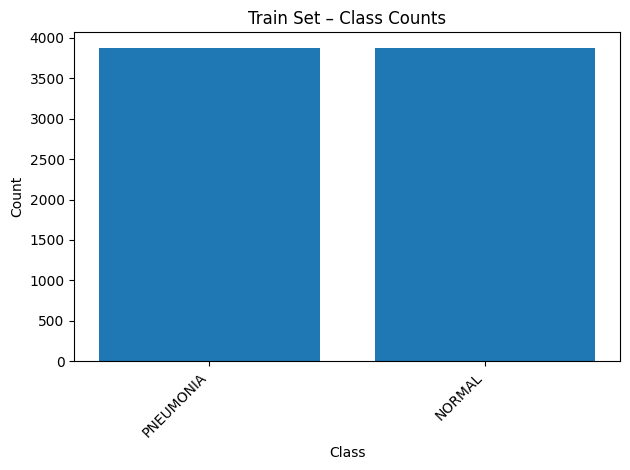

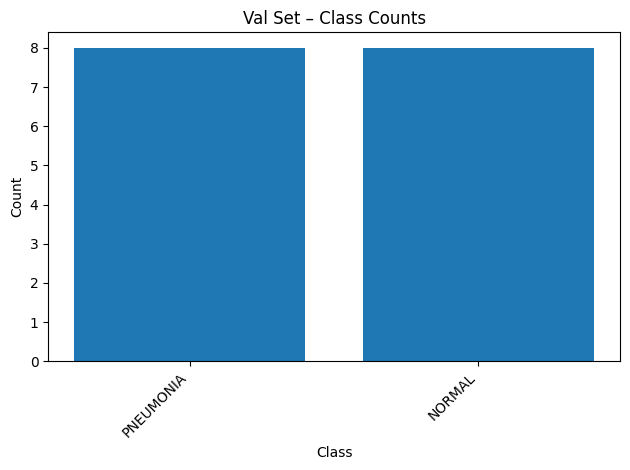

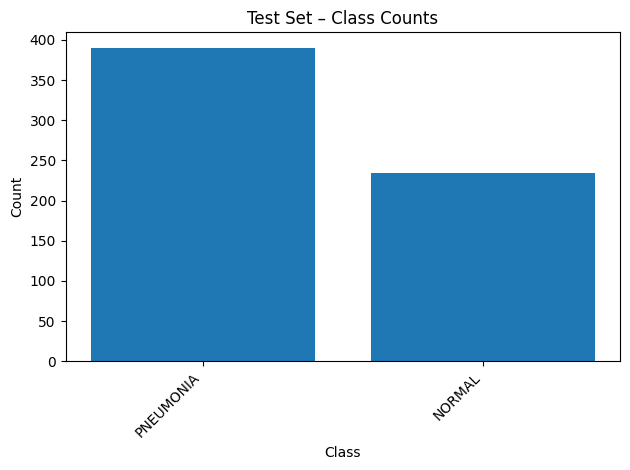

In [12]:
plot_distribution("data/processed/dataset1")